In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

"""
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
!pip install -q torchsummary

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.model_selection import train_test_split
from torchsummary import summary
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import OneCycleLR
import time
import warnings

warnings.filterwarnings("ignore")

In [3]:
# KANLinear class definition as provided
class KANLinear(nn.Module):
    def __init__(self, in_features, out_features, grid_size=5, spline_order=3, scale_noise=0.1, scale_base=1.0, scale_spline=1.0, enable_standalone_scale_spline=True, base_activation=nn.SiLU, grid_eps=0.02, grid_range=[-1, 1]):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = ((torch.arange(-spline_order, grid_size + spline_order + 1) * h + grid_range[0]).expand(in_features, -1).contiguous())
        self.register_buffer("grid", grid)

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(torch.Tensor(out_features, in_features, grid_size + spline_order))
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(torch.Tensor(out_features, in_features))

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = ((torch.rand(self.grid_size + 1, self.in_features, self.out_features) - 1 / 2) * self.scale_noise / self.grid_size)
            self.spline_weight.data.copy_((self.scale_spline if not self.enable_standalone_scale_spline else 1.0) * self.curve2coeff(self.grid.T[self.spline_order : -self.spline_order], noise))
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        grid = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = ((x - grid[:, : -(k + 1)]) / (grid[:, k:-1] - grid[:, : -(k + 1)]) * bases[:, :, :-1]) + ((grid[:, k + 1 :] - x) / (grid[:, k + 1 :] - grid[:, 1:(-k)]) * bases[:, :, 1:])
        assert bases.size() == (x.size(0), self.in_features, self.grid_size + self.spline_order)
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)
        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        result = solution.permute(2, 0, 1)
        assert result.size() == (self.out_features, self.in_features, self.grid_size + self.spline_order)
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (self.spline_scaler.unsqueeze(-1) if self.enable_standalone_scale_spline else 1.0)

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(self.b_splines(x).view(x.size(0), -1), self.scaled_spline_weight.view(self.out_features, -1))
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)
        splines = self.b_splines(x).permute(1, 0, 2)
        orig_coeff = self.scaled_spline_weight.permute(1, 2, 0)
        unreduced_spline_output = torch.bmm(splines, orig_coeff).permute(1, 0, 2)
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[torch.linspace(0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device)]
        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (torch.arange(self.grid_size + 1, dtype=torch.float32, device=x.device).unsqueeze(1) * uniform_step + x_sorted[0] - margin)
        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.cat([grid[:1] - uniform_step * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1), grid, grid[-1:] + uniform_step * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1)], dim=0)
        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return regularize_activation * regularization_loss_activation + regularize_entropy * regularization_loss_entropy



In [4]:
# Define a custom model by modifying the pre-trained MobileNetV2
class CustomMobileNetV2KAN(nn.Module):
    def __init__(self, num_classes=100):
        super(CustomMobileNetV2KAN, self).__init__()
        self.base_model = models.mobilenet_v2(pretrained=True).features
        
        # Add a new classifier on top
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            KANLinear(1280, num_classes)
        )
    
    def forward(self, x):
        x = self.base_model(x)
        x = self.classifier(x)
        return x


# Define a custom model by modifying the pre-trained MobileNetV2
"""
class CustomMobileNetV2KAN(nn.Module):
    def __init__(self, num_classes=100):
        super(CustomMobileNetV2KAN, self).__init__()
        self.base_model = models.mobilenet_v2(pretrained=True)
        
        # Freeze the base model layers
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        # Replace the classifier with a new one
        self.base_model.classifier[1] = KANLinear(self.base_model.last_channel, num_classes)
    
    def forward(self, x):
        x = self.base_model(x)
        return x
"""

'\nclass CustomMobileNetV2KAN(nn.Module):\n    def __init__(self, num_classes=100):\n        super(CustomMobileNetV2KAN, self).__init__()\n        self.base_model = models.mobilenet_v2(pretrained=True)\n        \n        # Freeze the base model layers\n        for param in self.base_model.parameters():\n            param.requires_grad = False\n        \n        # Replace the classifier with a new one\n        self.base_model.classifier[1] = KANLinear(self.base_model.last_channel, num_classes)\n    \n    def forward(self, x):\n        x = self.base_model(x)\n        return x\n'

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 110MB/s] 


CustomMobileNetV2KAN(
  (base_model): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm

100%|██████████| 169001437/169001437 [00:04<00:00, 35007992.29it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Train Epoch: 0 [0/50000 (0%)]	Loss: 4.710247
Train Epoch: 0 [1280/50000 (3%)]	Loss: 4.611087
Train Epoch: 0 [2560/50000 (6%)]	Loss: 4.644811
Train Epoch: 0 [3840/50000 (10%)]	Loss: 4.573834
Train Epoch: 0 [5120/50000 (13%)]	Loss: 4.514332
Train Epoch: 0 [6400/50000 (16%)]	Loss: 4.498208
Train Epoch: 0 [7680/50000 (19%)]	Loss: 4.474883
Train Epoch: 0 [8960/50000 (22%)]	Loss: 4.482147
Train Epoch: 0 [10240/50000 (26%)]	Loss: 4.481321
Train Epoch: 0 [11520/50000 (29%)]	Loss: 4.363797
Train Epoch: 0 [12800/50000 (32%)]	Loss: 4.425789
Train Epoch: 0 [14080/50000 (35%)]	Loss: 4.290742
Train Epoch: 0 [15360/50000 (38%)]	Loss: 4.267848
Train Epoch: 0 [16640/50000 (42%)]	Loss: 4.337886
Train Epoch: 0 [17920/50000 (45%)]	Loss: 4.134429
Train Epoch: 0 [19200/50000 (48%)]	Loss: 4.258933
Train Epoch: 0 [20480/50000 (51%)]	Loss: 4.246673
Train Epoch: 0 [21760/50000 (54%)]	Loss: 4.194317
Train Epoch: 0 [23040/50

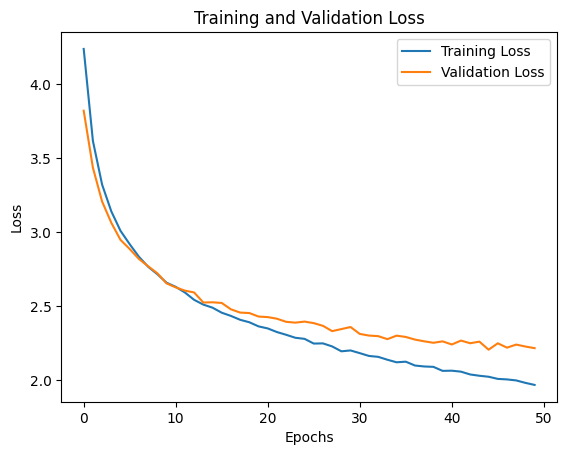

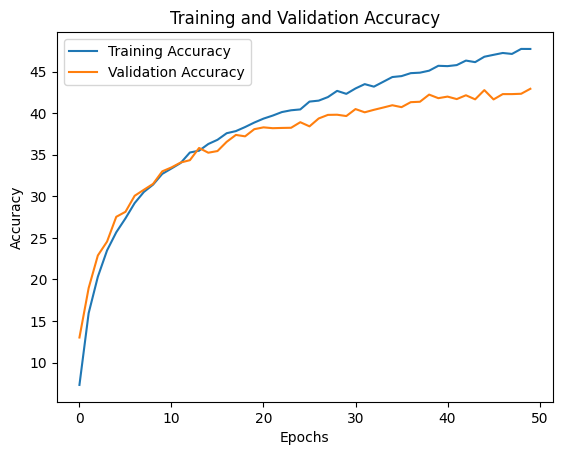

Epoch 1 duration: 0 hours, 0 minutes, 36 seconds
Epoch 2 duration: 0 hours, 0 minutes, 35 seconds
Epoch 3 duration: 0 hours, 0 minutes, 35 seconds
Epoch 4 duration: 0 hours, 0 minutes, 35 seconds
Epoch 5 duration: 0 hours, 0 minutes, 35 seconds
Epoch 6 duration: 0 hours, 0 minutes, 34 seconds
Epoch 7 duration: 0 hours, 0 minutes, 35 seconds
Epoch 8 duration: 0 hours, 0 minutes, 35 seconds
Epoch 9 duration: 0 hours, 0 minutes, 35 seconds
Epoch 10 duration: 0 hours, 0 minutes, 35 seconds
Epoch 11 duration: 0 hours, 0 minutes, 35 seconds
Epoch 12 duration: 0 hours, 0 minutes, 35 seconds
Epoch 13 duration: 0 hours, 0 minutes, 35 seconds
Epoch 14 duration: 0 hours, 0 minutes, 35 seconds
Epoch 15 duration: 0 hours, 0 minutes, 35 seconds
Epoch 16 duration: 0 hours, 0 minutes, 34 seconds
Epoch 17 duration: 0 hours, 0 minutes, 35 seconds
Epoch 18 duration: 0 hours, 0 minutes, 35 seconds
Epoch 19 duration: 0 hours, 0 minutes, 34 seconds
Epoch 20 duration: 0 hours, 0 minutes, 35 seconds
Epoch 21 

In [7]:
# Define number of classes according to your dataset
num_classes = 100  # CIFAR-100 has 100 classes

# Input jumlah epoch
epochs = 200
batch_size = 128

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model
model = CustomMobileNetV2KAN(num_classes=num_classes).to(device)
print(model)
summary(model, input_size=(3, 32, 32))

# DataParallel if more than one GPU is available
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

# Function to print model parameter details
def print_parameter_details(model):
    for name, param in model.named_parameters():
        print(f"{name}: {param.size()} {'requires_grad' if param.requires_grad else 'frozen'}")

print_parameter_details(model)

# Define transformations for training and validation data
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load CIFAR-100 dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_val)

# Split training set into train and validation sets
train_indices, val_indices = train_test_split(list(range(len(trainset))), test_size=0.2, stratify=trainset.targets)
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

# Define DataLoaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=val_sampler, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=epochs)

# Training function
def train(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(inputs)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

        torch.cuda.empty_cache()

    accuracy = 100 * correct / total
    return running_loss / len(train_loader), accuracy

# Validation function
def validate(model, val_loader, criterion, device, epoch):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            if batch_idx % 10 == 0:
                print(f'Validation Epoch: {epoch} [{batch_idx * len(inputs)}/{len(val_loader.dataset)} ({100. * batch_idx / len(val_loader):.0f}%)]\tLoss: {loss.item():.6f}')

            torch.cuda.empty_cache()

    accuracy = 100 * correct / total
    print(classification_report(all_labels, all_predictions))
    return val_loss / len(val_loader), accuracy

# Early stopping
best_val_loss = float('inf')
patience = 5
patience_counter = 0

# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Timing variables
epoch_times = []
total_start_time = time.time()

# Function to convert seconds to hours, minutes, seconds
def convert_seconds(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return hours, minutes, seconds

for epoch in range(epochs):
    epoch_start_time = time.time()

    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device, epoch)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device, epoch)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%")
    scheduler.step(val_loss)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    epoch_times.append(epoch_duration)
    hours, minutes, seconds = convert_seconds(epoch_duration)
    print(f"Epoch {epoch+1} duration: {hours} hours, {minutes} minutes, {seconds} seconds")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model_weights_KAN.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

total_end_time = time.time()
total_duration = total_end_time - total_start_time
total_hours, total_minutes, total_seconds = convert_seconds(total_duration)
print(f"Total training time: {total_hours} hours, {total_minutes} minutes, {total_seconds} seconds")

model.load_state_dict(torch.load('best_model_weights_KAN.pth'))

# Evaluate model on test set
def test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

            torch.cuda.empty_cache()

    accuracy = 100 * correct / total
    return accuracy, np.array(all_predictions), np.array(all_labels)

accuracy, preds, true_labels = test(model, test_loader, device)
print(f'Test Accuracy: {accuracy:.2f}%')

# Save predictions and labels for ROC plotting
np.save('preds.npy', preds)
np.save('true_labels.npy', true_labels)

# Plot training and validation loss
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Plot training and validation accuracy
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

for i, epoch_time in enumerate(epoch_times):
    hours, minutes, seconds = convert_seconds(epoch_time)
    print(f"Epoch {i+1} duration: {hours} hours, {minutes} minutes, {seconds} seconds")

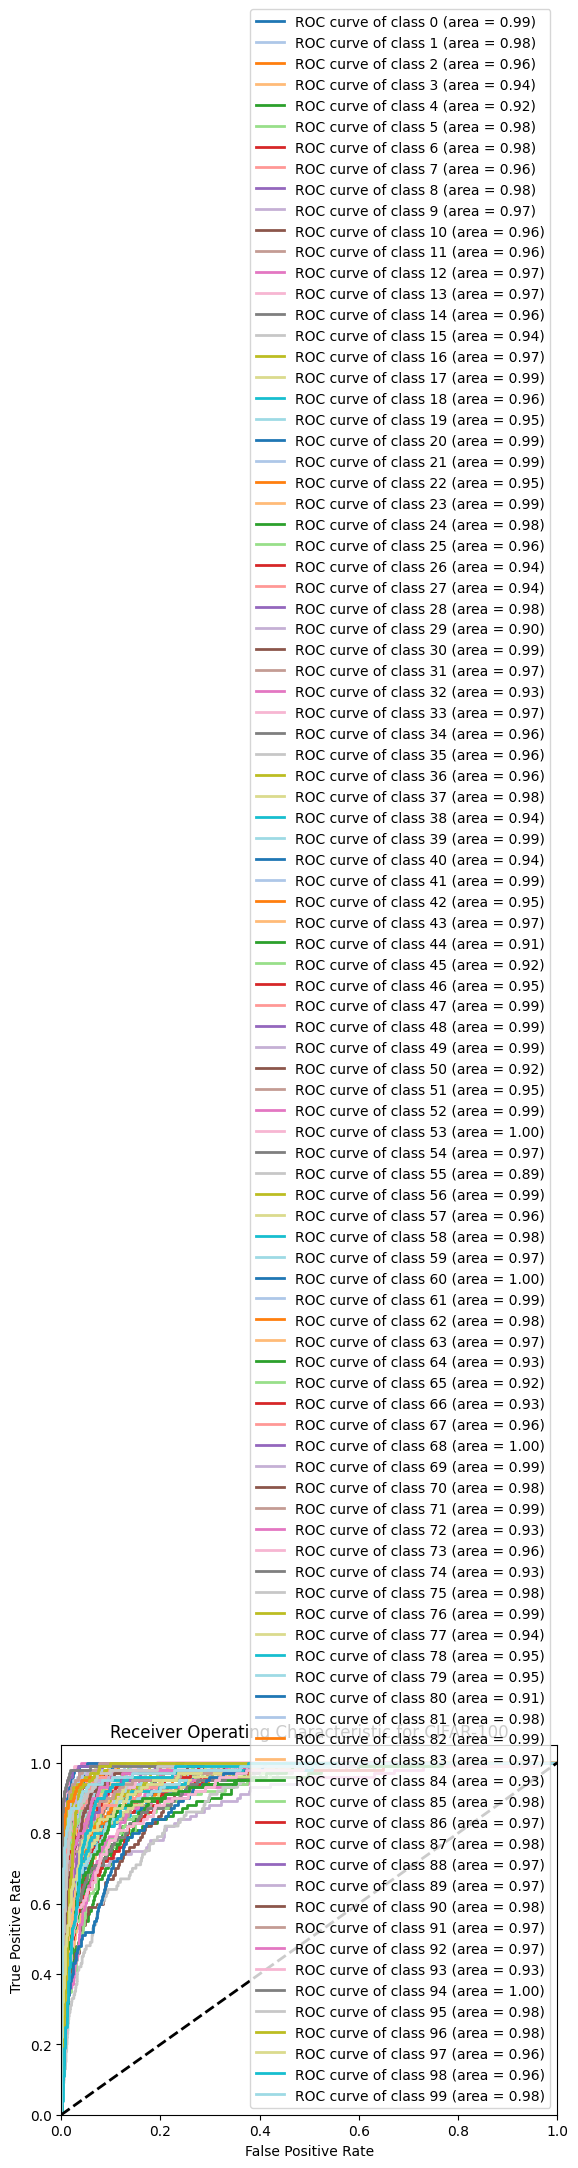

 
Accuracy: 0.5205
Precision: 0.5221
Recall: 0.5205
F1 Score: 0.5126
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.78      0.78      0.78       100
     Class 1       0.68      0.58      0.63       100
     Class 2       0.34      0.38      0.36       100
     Class 3       0.36      0.18      0.24       100
     Class 4       0.25      0.17      0.20       100
     Class 5       0.49      0.62      0.55       100
     Class 6       0.45      0.60      0.52       100
     Class 7       0.55      0.66      0.60       100
     Class 8       0.51      0.59      0.55       100
     Class 9       0.75      0.62      0.68       100
    Class 10       0.44      0.43      0.43       100
    Class 11       0.44      0.31      0.36       100
    Class 12       0.52      0.62      0.57       100
    Class 13       0.34      0.41      0.37       100
    Class 14       0.37      0.56      0.44       100
    Class 15       0.39      0.39      0.39

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize

# Load predictions and true labels
preds = np.load('preds.npy')
true_labels = np.load('true_labels.npy')

# Function to plot ROC curve for multi-class classification
def plot_roc_curve(true_labels, preds, n_classes):
    true_labels_bin = label_binarize(true_labels, classes=np.arange(n_classes))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    colors = plt.cm.get_cmap('tab20').colors
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i % 20], lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for CIFAR-100')
    plt.legend(loc="lower right")
    plt.show()

# Function to calculate and print classification metrics for multi-class classification
def print_classification_metrics(true_labels, preds, n_classes):
    preds_labels = np.argmax(preds, axis=1)
    accuracy = accuracy_score(true_labels, preds_labels)
    precision = precision_score(true_labels, preds_labels, average='macro')
    recall = recall_score(true_labels, preds_labels, average='macro')
    f1 = f1_score(true_labels, preds_labels, average='macro')
    report = classification_report(true_labels, preds_labels, target_names=[f'Class {i}' for i in range(n_classes)])

    print(" ")
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('Classification Report:')
    print(report)

# Plot ROC curve and print classification metrics
n_classes = 100
plot_roc_curve(true_labels, preds, n_classes)
print_classification_metrics(true_labels, preds, n_classes)
